# Capstone project: Predicting long-term stock gain using machine learning methods

## 1.	Data acquisition

### List of S&P 500 stocks in the consumer staples sector

Downloaded list of stocks in the S&P 500 index from the consumer staples sector (37 stocks), based on the Global Industry Classification Standard (GICS, https://www.msci.com/gics) from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). List of S&P 500 stocks with stocks in the consumer staples sector is saved in "S P 500 Stocks from Wikepidia.xlsx"

### Acquire stock historic quarterly financial data

For S&P 500 stocks from the consumer staples sector, extracted stock historic quarterly financial data (2009-2015), including EPS, Dividend, etc. from the 10-Q filings from the SEC’s EDGAR database (https://www.sec.gov/edgar/searchedgar/companysearch.html) using the pystock-crawler python package (https://pypi.python.org/pypi/pystock-crawler).

The following command was run to extract the data:
pystock-crawler reports "MO,ADM,BF.B,CPB,CHD,CLX,KO,CL,CAG,STZ,COST,COTY,CVS,DPS,EL,GIS,HRL,SJM,K,KMB,KHC,KR,MKC,MJN,TAP,MDLZ,MNST,PEP,PM,PG,RAI,SYY,HSY,TSN,WMT,WBA,WFM" -o consumer_staples_stocks_report.csv -l ./consumer_staples_stocks_crawling2.log

The financial data extracted from this process that will be utilized for prediction include:
symbol
end_date
revenues
eps_diluted
dividend
cur_assets
cur_liab

From "consumer_staples_stocks_report.csv", remove data after 2015 and save the resulting file to: consumer_staples_stocks_report_until_2015.xlsx

### Acquire stock historic pricing data

For each of those historic financial data records at quarter ending dates, extract the Adjusted Close Price from Yahoo Finance (https://finance.yahoo.com) using the yahoo-finance Python API: (https://pypi.python.org/pypi/yahoo-finance/1.1.4). If the stock price information is not available at the quarter ending date from the 10-Q filing, the Adjusted Close price at the next trading date when the price data is available is extracted. Similarly, extract the Adjusted Close Price for each stock one year (365 days) from each of the quarter ending dates. In addition, use this Python API to extract the current price and market capitalization data from Yahoo Finance.

Run the following Python code to perform the extraction of stock historic pricing data. All quarterly financial data for the following four stocks (KFT, HANS, WFMI, WXZ) were excluded from the input file for running the Python code, because attempt to extract historic price data from Yahoo Finance using the Python API was unsuccessful for some or all quarter ending dates for each of these stocks. After removing the quarterly financial data for these four stocks from "consumer_staples_stocks_report_until_2015.xlsx", "consumer_staples_stocks_report_until_2015.csv" was created as input file to the Python code.

In addition to extracting the historic price and market capitalization data from Yahoo Finance, the following calculations were made to create new columns of data that were written to the output file:

1. p_e ratio: p_e = Adjusted Close Price / (eps_diluted * 4)
2. Estimated market capitalization (in billions) at the quarter ending date = (Current Market Cap * Adjusted Close Price at quater ending date) / Current stock price)
3. Current ratio = Current Assets / Current Liability
4. Gain is the outcome variable to be predicted. Gain = 1 if Adjusted Close price is at least 10% higher in one year for each stock at each of the quarter ending dates. Gain = 0 otherwise.

After running the following Python code, the extracted data along with calculated data were appended to the input file as new columns and saved to: "consumer_staples_stocks_report_until_2015_out.csv"

In [ ]:
import pandas as pd
import datetime
import yahoo_finance
from yahoo_finance import Share

input_filename = "consumer_staples_stocks_report_until_2015.csv"

data = pd.read_csv(input_filename)

# This function will return the Adjusted Close price at the specific date from Yahoo Finance,
# if the price data is available at that date. Otherwise, the Adjusted Close price at the next trading date
# when the price data is available is returned. The date at which the Adjusted Close price is returned is also
# vreturned
def get_nearest_adj_close (stock_symbol, date_object):
	result = None
	stock = Share(stock_symbol)
    # Referred to http://stackoverflow.com/questions/4606919/in-python-try-until-no-error for code examples
    while result is None:
		try:
			result = stock.get_historical(date_object.strftime('%Y-%m-%d'), date_object.strftime('%Y-%m-%d'))
		except yahoo_finance.YQLResponseMalformedError:
			date_object += datetime.timedelta(days=1)
	return (result[0]['Adj_Close'], date_object)

adj_close_list = []
adj_close_actual_date_list = []
adj_close_1_year_list = []
adj_close_1_year_actual_date_list = []
market_cap_list = []
current_ratio_list = []
p_e_list = []
gain_list = []


for i in range(len(data)):
	#if i % 20 == 1:
	print 'Completed', i
	#stock = Share(data['symbol'][i])
	#print data['symbol'][i]

	stock = Share(data['symbol'][i])
	# get current price
	current_price = stock.get_price()
	# get current market cap
	current_market_cap = stock.get_market_cap()

	date_formatted = pd.to_datetime(data['end_date'][i])
	(adj_close_price, date_formatted_new) = get_nearest_adj_close(data['symbol'][i], date_formatted)
	adj_close_list.append(adj_close_price)
	adj_close_actual_date_list.append(date_formatted_new)

	(adj_close_price2, date_formatted_new2) = get_nearest_adj_close(data['symbol'][i], date_formatted+datetime.timedelta(days=365))
	adj_close_1_year_list.append(adj_close_price2)
	adj_close_1_year_actual_date_list.append(date_formatted_new2)

	market_cap_list.append(float(current_market_cap[:-1])*float(adj_close_price)/float(current_price))

	current_ratio_list.append(float(data['cur_assets'][i])/float(data['cur_liab'][i]))

	p_e_list.append(float(adj_close_price)/(4*float(data['eps_diluted'][i])))

	gain_list.append(1 if float(adj_close_price2) >= (float(adj_close_price) * 1.1) else 0)

data['adj_close'] = adj_close_list
data['adj_close_actual_date'] = adj_close_actual_date_list
data['adj_close_1_year'] = adj_close_1_year_list
data['adj_close_1_year_actual_date'] = adj_close_1_year_actual_date_list
data['market_cap'] = market_cap_list
data['current_ratio'] = current_ratio_list
data['p_e'] = p_e_list
data['gain'] = gain_list

#print data

data.to_csv("consumer_staples_stocks_report_until_2015_out.csv", index=False)


## 2. Data preprocessing

### Data cleansing

1. Remove records with duplicate keys (symbol + end_date).
2. Remove records where earnings per share is negative.
3. Set the index of the dataframe to be stock symbol and date of financial report.
4. Keep only columns that are needed for classification and drop the other columns

In [5]:
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

input_filename = "consumer_staples_stocks_report_until_2015_out.csv"

# Load the data
data = pd.read_csv(input_filename)

# Display a description of the dataset
display(data.describe())

n_records = data.shape[0]

# Number of records where the stock gained at least 10% in one year (gain =1)
n_gain_1 = data[data.gain == 1].shape[0]

# Number of records where the stock gained less than 10% in one year (gain = 0)
n_gain_0 = data[data.gain == 0].shape[0]

# Percentage of  records where the stock gained at least 10% in one year (gain =1)
gain_1_percent = n_gain_1*100.0/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Number of records where the stock gained at least 10% in one year: {}".format(n_gain_1)
print "Number of records where the stock gained less than 10% in one year: {}".format(n_gain_0)
print "Percentage of records where the stock gained at least 10% in one year: {:.2f}%".format(gain_1_percent)


# These records contain duplicate keys (symbol + end_date), according to the error
# output by running the following python code:
# data.set_index(['symbol', 'end_date'], drop=False, append=False, inplace=True, verify_integrity=True)
#
# [('DPS', '2011-09-30'), ('KMB', '2010-03-31'), ('KMB', '2011-09-30'), ('WMT', '2013-07-31')]

display(data[(data.symbol + data.end_date == 'DPS2011-09-30')])
display(data[(data.symbol + data.end_date == 'KMB2010-03-31')])
display(data[(data.symbol + data.end_date == 'KMB2011-09-30')])
display(data[(data.symbol + data.end_date == 'WMT2013-07-31')])

# Drop records with duplicate keys. Note that Record with index =56
# "KMB	2010-03-31	4.835000e+03	0.92	0.66	5719	5256" contains values for cur_assets and cur_liab
# that did not look like on the same scale as all the other records. This record is among what is dropped.
data.drop([172,56,181,385], inplace=True)

# Check if duplicate records are indeed dropped
display(data[(data.symbol + data.end_date == 'DPS2011-09-30')])
display(data[(data.symbol + data.end_date == 'KMB2010-03-31')])
display(data[(data.symbol + data.end_date == 'KMB2011-09-30')])
display(data[(data.symbol + data.end_date == 'WMT2013-07-31')])

# Set the index of the dataframe to be stock symbol and date of financial report
data['symbol_end_date'] = data['symbol'] + '@' + data['end_date']
data.set_index('symbol_end_date', drop=True, append=False, inplace=True, verify_integrity=True)

# Identify records where eps_diluted is zero or negative
display(data[data.eps_diluted <= 0])

# For the purpose of this project to build a classifier for stock long-term gain, these records with negative
# earnings will be deleted, as the number of these records is relatively small and in reality it is much more
# challenging to predict the return of stocks with negative earnings.

data.drop(['KR@2009-11-07', 'COTY@2014-03-31', 'TAP@2014-09-30', 'CAG@2015-02-22', 'KHC@2015-06-28', \
          'KMB@2015-06-30', 'HSY@2015-07-05', 'KHC@2015-09-27'], inplace=True)

# Display the first three records
display(data.head(n=3))

data.drop(labels=['symbol', 'end_date', 'cur_assets', 'cur_liab', 'adj_close_actual_date', 'adj_close_1_year',\
           'adj_close_1_year_actual_date'], axis=1, inplace=True)

# Display the first three records for the remaining dataframe
display(data.head(n=3))

# Check if there is any missing value in the dataframe
if data.isnull().values.any() == False:
    print 'No missing data. Great!'
else:
    print 'Unfortunately there is missing data'

#data2 = pd.read_csv('consumer_staples_stocks_report_until_2015_out_test.csv')
#print (data2.isnull().values.any())
#display(data2.head(n=16))



,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_1_year,market_cap,current_ratio,p_e,gain
count,5.870000e+02,587.000000,587.000000,5.870000e+02,5.870000e+02,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000
mean,1.082493e+10,0.832845,0.409080,9.262156e+09,8.547075e+09,46.301053,54.425344,38.512371,1.398893,16.231184,0.652470
std,1.952030e+10,0.736859,1.033678,1.191151e+10,1.296963e+10,24.146309,28.717663,47.272328,0.737733,24.771381,0.476592
min,-1.000000e+06,-2.230000,0.000000,5.719000e+03,5.256000e+03,6.614944,9.569198,3.202275,0.567011,-93.809167,0.000000
25%,1.545058e+09,0.555000,0.170000,1.955310e+09,1.401250e+09,28.365897,32.541296,10.111996,0.943127,9.527540,0.000000
50%,3.856000e+09,0.770000,0.320000,4.457400e+09,3.620000e+09,42.085853,48.866338,16.927508,1.180152,13.412638,1.000000
75%,1.268000e+10,1.060000,0.490000,1.347550e+10,1.157800e+10,62.361115,72.295689,44.307588,1.683445,18.597077,1.000000
max,1.193360e+11,14.850000,24.000000,6.714200e+10,7.702100e+10,144.295689,161.160236,227.409768,7.973498,384.444458,1.000000


Total number of records: 587
Number of records where the stock gained at least 10% in one year: 383
Number of records where the stock gained less than 10% in one year: 204
Percentage of records where the stock gained at least 10% in one year: 65.25%


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
171,DPS,2011-09-30,1.529000e+09,0.71,0.32,1695000000,1726000000,33.428684,2011-09-30,39.756259,2012-10-01,6.122288,0.982039,11.770663,1
172,DPS,2011-09-30,1.529000e+09,0.71,0.32,1695000000,1726000000,33.428684,2011-09-30,39.756259,2012-10-01,6.122288,0.982039,11.770663,1


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
55,KMB,2010-03-31,4.835000e+09,0.92,0.66,5719000000,5256000000,47.653186,2010-03-31,51.602509,2011-03-31,16.97804,1.08809,12.949235,0
56,KMB,2010-03-31,4.835000e+03,0.92,0.66,5719,5256,47.653186,2010-03-31,51.602509,2011-03-31,16.97804,1.08809,12.949235,0


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
180,KMB,2011-09-30,5.382000e+09,1.09,0.7,6539000000,5816000000,57.33122,2011-09-30,72.515525,2012-10-01,20.42363,1.124312,13.149362,1
181,KMB,2011-09-30,5.382000e+09,1.09,0.7,6539000000,5816000000,57.33122,2011-09-30,72.515525,2012-10-01,20.42768,1.124312,13.149362,1


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
384,WMT,2013-07-31,1.162160e+11,1.24,0.0,60002000000,72214000000,71.043328,2013-07-31,68.729951,2014-07-31,218.328758,0.830892,14.323252,0
385,WMT,2013-07-31,1.162160e+11,1.24,0.0,60002000000,72214000000,71.043328,2013-07-31,68.729951,2014-07-31,218.330690,0.830892,14.323252,0


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
171,DPS,2011-09-30,1.529000e+09,0.71,0.32,1695000000,1726000000,33.428684,2011-09-30,39.756259,2012-10-01,6.122288,0.982039,11.770663,1


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
55,KMB,2010-03-31,4.835000e+09,0.92,0.66,5719000000,5256000000,47.653186,2010-03-31,51.602509,2011-03-31,16.97804,1.08809,12.949235,0


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
180,KMB,2011-09-30,5.382000e+09,1.09,0.7,6539000000,5816000000,57.33122,2011-09-30,72.515525,2012-10-01,20.42363,1.124312,13.149362,1


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
384,WMT,2013-07-31,1.162160e+11,1.24,0.0,60002000000,72214000000,71.043328,2013-07-31,68.729951,2014-07-31,218.328758,0.830892,14.323252,0


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
symbol_end_date,,,,,,,,,,,,,,,
KR@2009-11-07,KR,2009-11-07,1.766900e+10,-1.35,0.095,7530000000,8164000000,10.493115,2009-11-09,10.232602,2010-11-08,9.843211,0.922342,-1.943169,0
COTY@2014-03-31,COTY,2014-03-31,1.008700e+09,-0.66,0.000,2697000000,1506400000,14.420025,2014-03-31,23.638908,2015-03-31,10.769862,1.790361,-5.462131,1
TAP@2014-09-30,TAP,2014-09-30,1.168000e+09,-0.19,0.370,1811900000,2619800000,71.294967,2014-09-30,81.264050,2015-09-30,15.325617,0.691618,-93.809167,1
CAG@2015-02-22,CAG,2015-02-22,3.876700e+09,-2.23,0.250,3923300000,3716900000,25.654857,2015-02-23,31.926688,2016-02-22,11.168159,1.055530,-2.876105,1
KHC@2015-06-28,KHC,2015-06-28,-1.000000e+06,-0.91,0.000,4589000000,2653000000,69.805839,2015-07-06,83.069160,2016-06-27,84.953094,1.729740,-19.177428,1
KMB@2015-06-30,KMB,2015-06-30,4.643000e+09,-0.83,0.880,5518000000,6765000000,101.296012,2015-06-30,132.665641,2016-06-29,36.090090,0.815669,-30.510847,1
HSY@2015-07-05,HSY,2015-07-05,1.578825e+09,-0.89,0.486,2007447000,2018272000,85.608726,2015-07-06,109.950127,2016-07-05,18.223066,0.994637,-24.047395,1
KHC@2015-09-27,KHC,2015-09-27,6.120000e+09,-0.27,0.550,10411000000,5746000000,66.954189,2015-09-28,87.897643,2016-09-26,81.483270,1.811869,-61.994619,1


,symbol,end_date,revenues,eps_diluted,dividend,cur_assets,cur_liab,adj_close,adj_close_actual_date,adj_close_1_year,adj_close_1_year_actual_date,market_cap,current_ratio,p_e,gain
symbol_end_date,,,,,,,,,,,,,,,
TAP@2009-06-28,TAP,2009-06-28,7.989000e+08,1.01,0.0000,1333300000,1098500000,35.477692,2009-06-29,37.232940,2010-06-28,7.626079,1.213746,8.781607,0
CVS@2009-06-30,CVS,2009-06-30,2.487110e+10,0.60,0.0763,16771600000,12763800000,28.506514,2009-06-30,26.470082,2010-06-30,30.247070,1.313997,11.877714,0
CL@2009-06-30,CL,2009-06-30,3.745000e+09,1.07,0.0000,4217800000,3240200000,29.484818,2009-06-30,33.605433,2010-06-30,26.172913,1.301710,6.888976,1


,revenues,eps_diluted,dividend,adj_close,market_cap,current_ratio,p_e,gain
symbol_end_date,,,,,,,,
TAP@2009-06-28,7.989000e+08,1.01,0.0000,35.477692,7.626079,1.213746,8.781607,0
CVS@2009-06-30,2.487110e+10,0.60,0.0763,28.506514,30.247070,1.313997,11.877714,0
CL@2009-06-30,3.745000e+09,1.07,0.0000,29.484818,26.172913,1.301710,6.888976,1


No missing data. Great!


### Data exploration

1. Examine the overall range of each feature
2. Examine the number of records in each of the binary classes (gain = 1 or 0)
3. Plot the histogram of each feature to examine the data distribution

In [6]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Function to plot a histogram for a column in the above dataframe
# Written based on http://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html
def plot_histogram(data, column_to_plot):
    #column_to_plot = 'revenues'
    n, bins, patches = plt.hist(data[column_to_plot], 50, facecolor='green', alpha=0.75)

    plt.xlabel(column_to_plot)
    plt.ylabel('Count')
    plt.title('Histogram of '+column_to_plot)
    plt.grid(True)
    plt.show()

Total number of records: 575
Number of records where the stock gained at least 10% in one year: 374
Number of records where the stock gained less than 10% in one year: 201
Percentage of records where the stock gained at least 10% in one year: 65.04%


,revenues,eps_diluted,dividend,adj_close,market_cap,current_ratio,p_e,gain
count,5.750000e+02,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000
mean,1.077399e+10,0.856087,0.410120,46.128232,38.394863,1.404023,16.896232,0.650435
std,1.919100e+10,0.711041,1.043567,24.044357,47.001339,0.742518,24.152134,0.477248
min,2.918000e+08,0.020000,0.000000,6.614944,3.202275,0.567011,0.910776,0.000000
25%,1.559729e+09,0.570000,0.172500,28.365897,10.098898,0.946112,9.729669,0.000000
50%,3.856000e+09,0.770000,0.320000,41.990001,16.913842,1.183335,13.555426,1.000000
75%,1.274300e+10,1.065000,0.488000,61.394795,44.307588,1.683445,18.777818,1.000000
max,1.193360e+11,14.850000,24.000000,144.295689,227.409768,7.973498,384.444458,1.000000


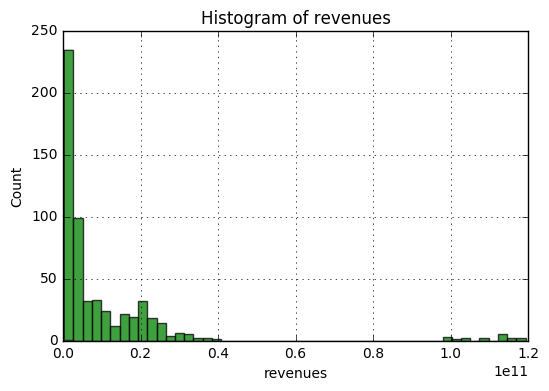

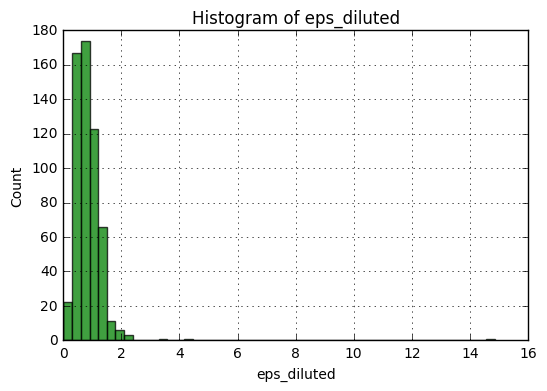

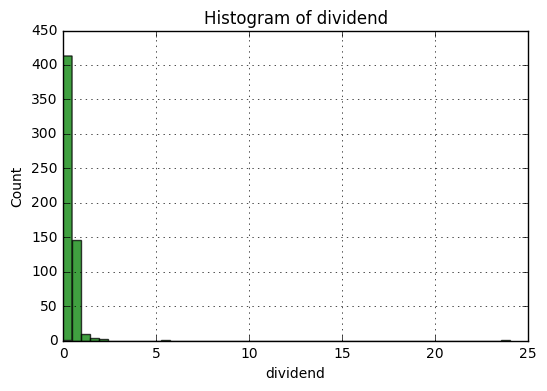

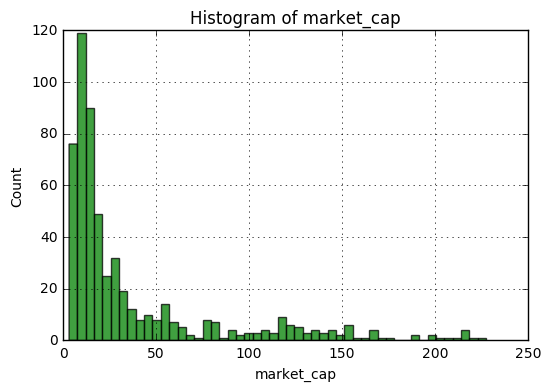

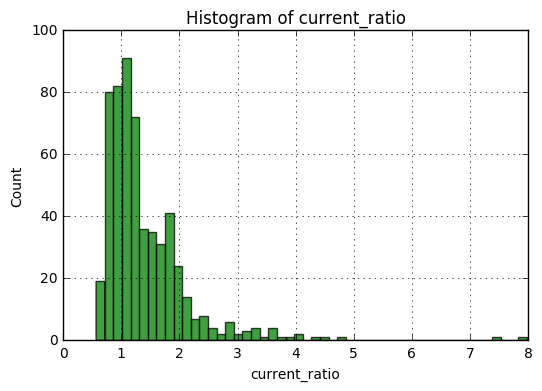

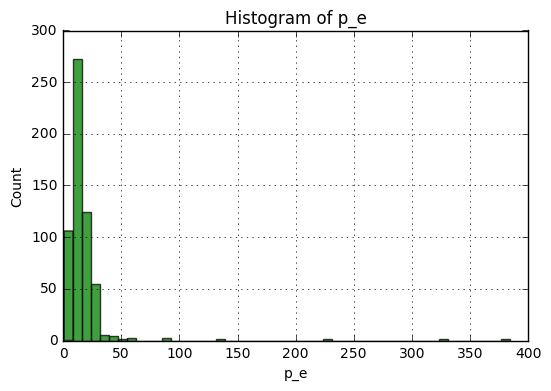

In [7]:
n_records = data.shape[0]

# Number of records where the stock gained at least 10% in one year (gain =1)
n_gain_1 = data[data.gain == 1].shape[0]

# Number of records where the stock gained less than 10% in one year (gain = 0)
n_gain_0 = data[data.gain == 0].shape[0]

# Percentage of  records where the stock gained at least 10% in one year (gain =1)
gain_1_percent = n_gain_1*100.0/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Number of records where the stock gained at least 10% in one year: {}".format(n_gain_1)
print "Number of records where the stock gained less than 10% in one year: {}".format(n_gain_0)
print "Percentage of records where the stock gained at least 10% in one year: {:.2f}%".format(gain_1_percent)

# Display a description of the dataset
display(data.describe())

# Closely examine the range and distribution for each column of data

# revenues
plot_histogram(data, 'revenues')

# eps_diluted
plot_histogram(data, 'eps_diluted')

# dividend
plot_histogram(data, 'dividend')

# market_cap
plot_histogram(data, 'market_cap')

# current_ratio
plot_histogram(data, 'current_ratio')

# p_e
plot_histogram(data, 'p_e')

#display(data.head(n=3))

### Data transformation

1. Log transform the data, since most of the features appear to have skewed distrubution
2. Scale the log transformed data such that each feature will have a mean of 0 and unit standard deviation across all records

,revenues,eps_diluted,dividend,adj_close,market_cap,current_ratio,p_e
count,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000,575.000000
mean,22.237775,-0.297370,-1.682870,3.684992,3.085633,0.245632,2.597830
std,1.276147,0.548268,1.883049,0.566700,1.010391,0.408457,0.595807
min,19.491579,-3.863233,-6.907755,1.889482,1.164174,-0.565614,-0.092361
25%,21.167778,-0.560366,-1.751682,3.345222,2.312525,-0.054340,2.275282
50%,22.072896,-0.260067,-1.136314,3.737455,2.828191,0.169181,2.606861
75%,23.268248,0.063902,-0.715401,4.117341,3.791176,0.521436,2.932729
max,25.505209,2.698067,3.178095,4.971872,5.426758,2.076249,5.951802


,revenues,eps_diluted,dividend,adj_close,market_cap,current_ratio,p_e
symbol_end_date,,,,,,,
TAP@2009-06-28,20.498746,0.010940,-6.907755,3.568932,2.031705,0.194535,2.172773
CVS@2009-06-30,23.936972,-0.509160,-2.560061,3.350168,3.409432,0.273835,2.474748
CL@2009-06-30,22.043687,0.068593,-6.907755,3.383909,3.264763,0.264447,1.930068


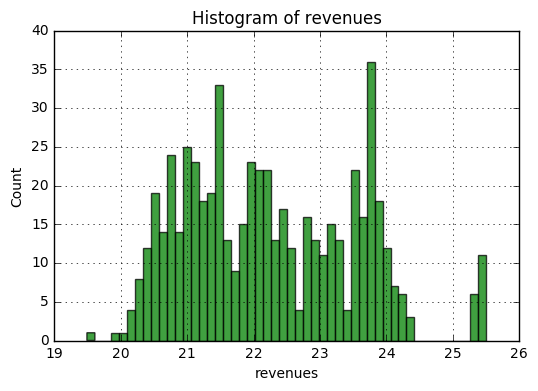

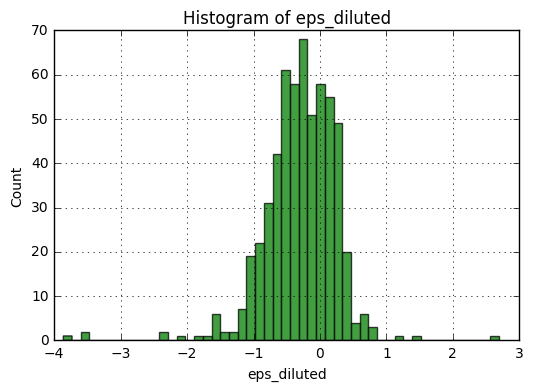

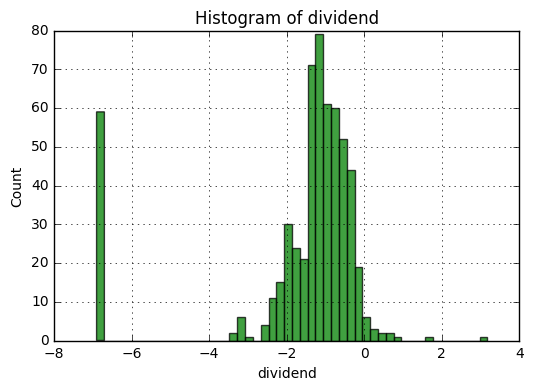

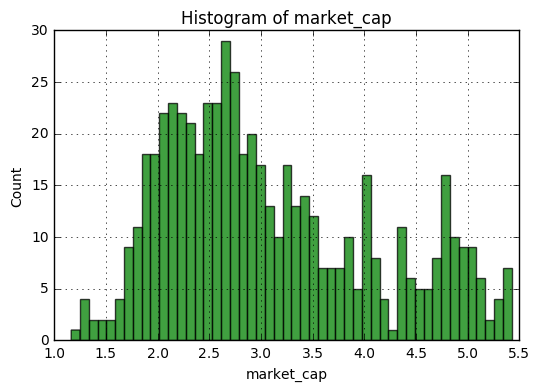

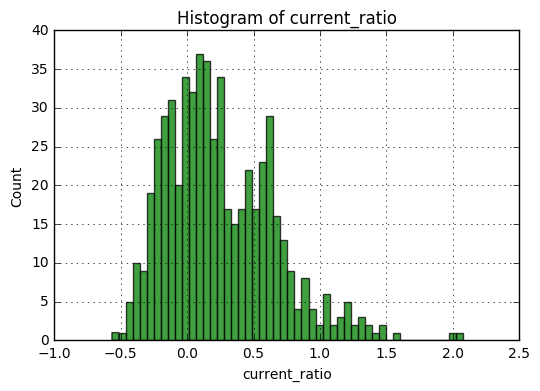

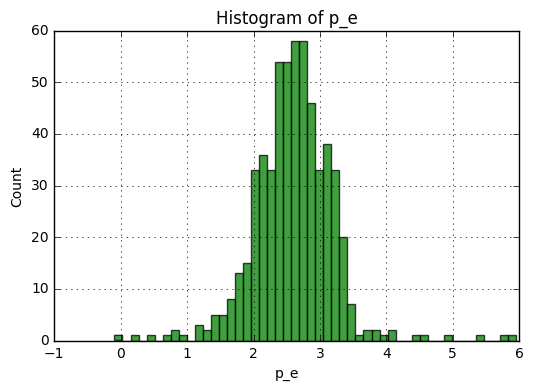

,revenues,eps_diluted,dividend,adj_close,market_cap,current_ratio,p_e
count,5.750000e+02,5.750000e+02,5.750000e+02,5.750000e+02,5.750000e+02,5.750000e+02,5.750000e+02
mean,-4.220778e-16,-5.502845e-17,-4.238156e-17,1.650853e-17,6.893037e-17,-1.351576e-17,1.199041e-16
std,1.000871e+00,1.000871e+00,1.000871e+00,1.000871e+00,1.000871e+00,1.000871e+00,1.000871e+00
min,-2.153817e+00,-6.509534e+00,-2.777110e+00,-3.171120e+00,-1.903354e+00,-1.987851e+00,-4.519135e+00
25%,-8.391889e-01,-4.801034e-01,-3.657461e-02,-6.000808e-01,-7.658231e-01,-7.350420e-01,-5.418344e-01
50%,-1.293127e-01,6.809701e-02,2.905029e-01,9.265700e-02,-2.550157e-01,-1.873314e-01,1.516958e-02
75%,8.081908e-01,6.595075e-01,5.142249e-01,7.635882e-01,6.988949e-01,6.758223e-01,5.625824e-01
max,2.562619e+00,5.468213e+00,2.583680e+00,2.272808e+00,2.319066e+00,4.485686e+00,5.634191e+00


,revenues,eps_diluted,dividend,adj_close,market_cap,current_ratio,p_e
symbol_end_date,,,,,,,
TAP@2009-06-28,-1.363904,0.562824,-2.777110,-0.204978,-1.043997,-0.125206,-0.714035
CVS@2009-06-30,1.332665,-0.386627,-0.466241,-0.591347,0.320748,0.069108,-0.206761
CL@2009-06-30,-0.152221,0.668070,-2.777110,-0.531754,0.177442,0.046103,-1.121746


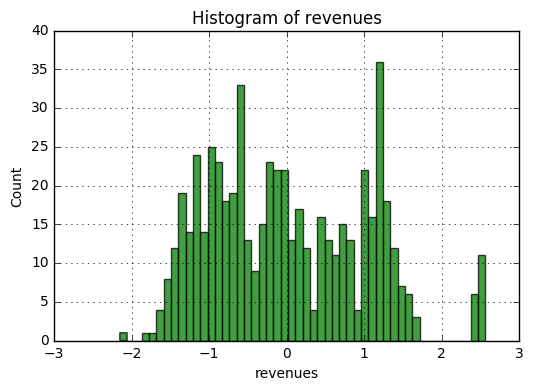

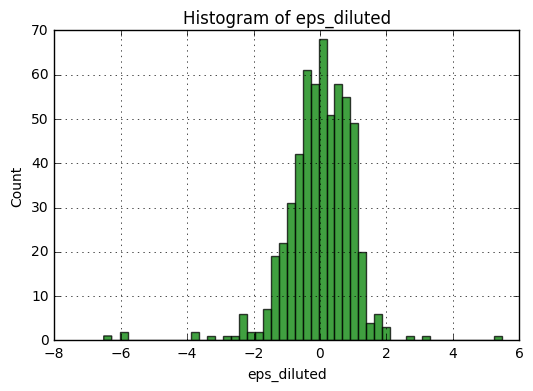

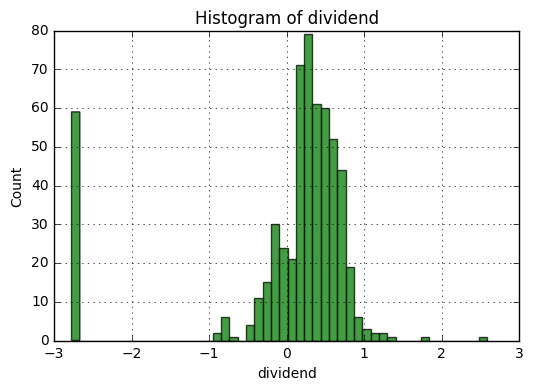

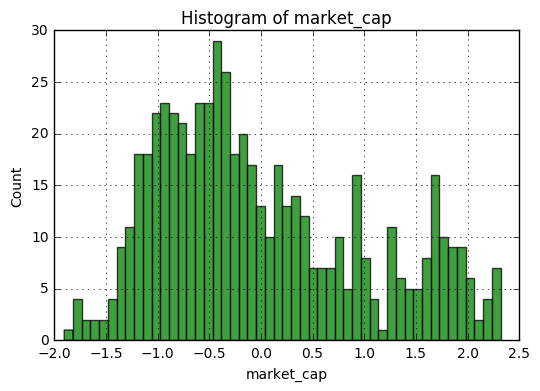

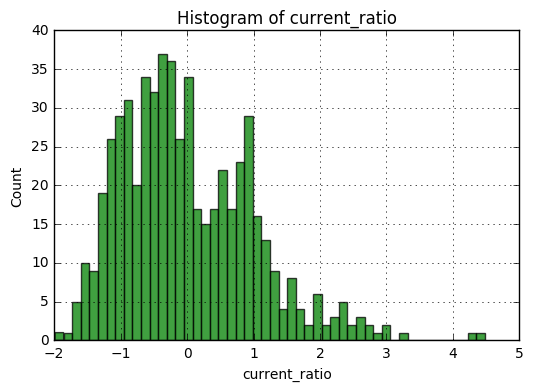

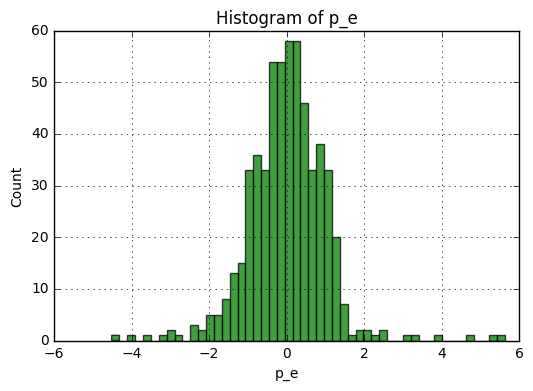

In [8]:
from sklearn import preprocessing

# Split the data into features and target label
gain = data['gain']
features_raw = data.drop('gain', axis = 1)

# Apply log transformation on the data for all features
#all_features = ['revenues', 'eps_diluted', 'dividend', 'adj_close', 'market_cap', 'current_ratio', 'p_e']
features_raw = features_raw.apply(lambda x: np.log(x + 0.001))

# Check on the transformed data

# Display a description of the dataset
display(features_raw.describe())

display(features_raw.head(n=3))

# Plot histograms after log transformation

# revenues
plot_histogram(features_raw, 'revenues')

# eps_diluted
plot_histogram(features_raw, 'eps_diluted')

# dividend
plot_histogram(features_raw, 'dividend')

# market_cap
plot_histogram(features_raw, 'market_cap')

# current_ratio
plot_histogram(features_raw, 'current_ratio')

# p_e
plot_histogram(features_raw, 'p_e')

#features_raw.to_csv("before_scale.csv", index=False)

# Scale the data
# Referred to the following source for code example
# http://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
features = pd.DataFrame(preprocessing.scale(features_raw), columns=features_raw.columns, index=features_raw.index)

#preprocessing.scale(data, axis=0, with_mean=True, with_std=True, copy=True)

#scaled_data[0:2]

display(features.describe())

display(features.head(n=3))

#features.to_csv("after_scale.csv", index=False)

# Plot histograms after scaling

# revenues
plot_histogram(features, 'revenues')

# eps_diluted
plot_histogram(features, 'eps_diluted')

# dividend
plot_histogram(features, 'dividend')

# market_cap
plot_histogram(features, 'market_cap')

# current_ratio
plot_histogram(features, 'current_ratio')

# p_e
plot_histogram(features, 'p_e')

preprocessed_data = features

preprocessed_data['gain'] = gain

# Save preprocessed data along with the target variable to a file
preprocessed_data.to_csv("consumer_staples_stocks_report_until_2015_out_preprocessed.csv", index=False)

## 3. Shuffle and Split Data

In [3]:
import pandas as pd
# Import train_test_split
from sklearn.cross_validation import train_test_split
import numpy as np

# Load the data
data = pd.read_csv("consumer_staples_stocks_report_until_2015_out_preprocessed.csv")

# Split the data into features and target label
gain = data['gain']
features = data.drop('gain', axis = 1)

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, gain, test_size = 0.2, random_state = 3)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])


Training set has 460 samples.
Testing set has 115 samples.


## 4. Evaluate Model Performance

### Evaluation metrics and Naive predictor

As there are over 65% of records where the stock gained at least 10% in one year, the dataset is skewed towards more samples with the target = 1. Therefore, I will plan to evaluate the model by both the overall prediction accuracy but will place greater emphasis on the F-beta score with beta=0.5. I believe for investment return, it is more important to be able to make correct prediction than covering correct prediction on more positive cases (all the stocks that will gain at least 10% in one year). In other words, the precision is more important than the recall value.

For a Naive predictor, it will predict 1 for all cases. Given that there are more cases where the target value is 1, the Naive predictor will be generally correct. My goal is to develop a predictor using supervised learning methods that performed better than the Naive predictor.

### Performace of a Naive Predictor

In [16]:
# The following code is adapted from the code from the Udacity Project "Finding Donors"
y_pred = [1] * len(gain)
accuracy = sum([i == j for i, j in zip(gain, y_pred)])*1.0/len(gain)
#print accuracy

# Calculate F-score using the formula above for beta = 0.5
#precision = precision_score(income, y_pred)
TP = sum([i == j for i, j in zip(gain, y_pred) if i == 1])*1.0
FP = sum([i != j for i, j in zip(gain, y_pred) if j == 1])*1.0
FN = sum([i != j for i, j in zip(gain, y_pred) if j == 0])*1.0

precision = TP/(TP+FP)
#print precision

recall = TP/(TP+FN)
#print recall

beta = 0.5
fscore = (1+np.square(beta))*precision*recall/((np.square(beta)*precision)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.6504, F-score: 0.6993]


### Create a Training and Predicting Pipeline

In [14]:
# The following code and visuals.py are copied from the code from the Udacity Project "Finding Donors". 

from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

from time import time
# Import supplementary visualization code visuals.py -- This is copied from the Udacity Project "Finding Donors"
import visuals as vs


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Initial Model Evaluation

DecisionTreeClassifier trained on 4 samples.
DecisionTreeClassifier trained on 46 samples.
DecisionTreeClassifier trained on 460 samples.
GaussianNB trained on 4 samples.
GaussianNB trained on 46 samples.
GaussianNB trained on 460 samples.
KNeighborsClassifier trained on 4 samples.
KNeighborsClassifier trained on 46 samples.
KNeighborsClassifier trained on 460 samples.


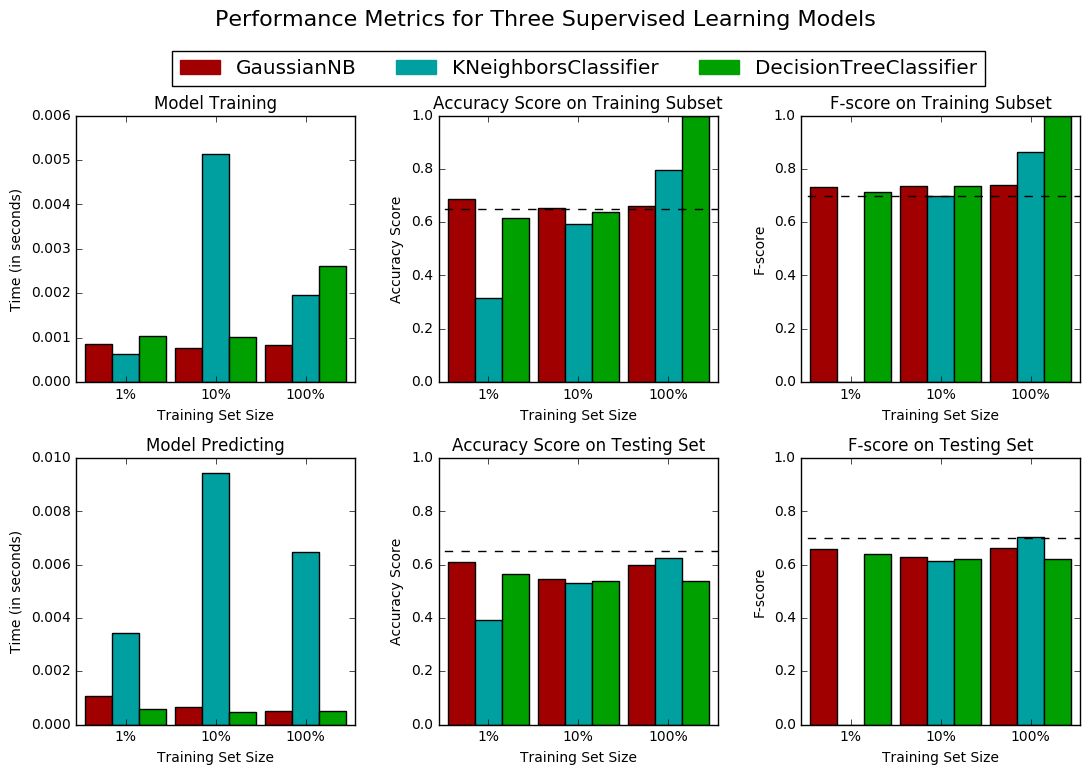

In [14]:
# The following code is adapted from the code from the Udacity Project "Finding Donors"

# Import the three supervised learning models from sklearn
from sklearn import tree
from sklearn import naive_bayes
from sklearn import neighbors

# TODO: Initialize the three models
clf_A = tree.DecisionTreeClassifier(random_state=1)
clf_B = naive_bayes.GaussianNB()
clf_C = neighbors.KNeighborsClassifier(n_neighbors=4)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]/100
#print "Training set has {} samples.".format(X_train.shape[0])
#print samples_1
samples_10 = X_train.shape[0]/10
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

RandomForestClassifier trained on 4 samples.
RandomForestClassifier trained on 46 samples.
RandomForestClassifier trained on 460 samples.
SVC trained on 4 samples.
SVC trained on 46 samples.
SVC trained on 460 samples.
LogisticRegression trained on 4 samples.
LogisticRegression trained on 46 samples.
LogisticRegression trained on 460 samples.


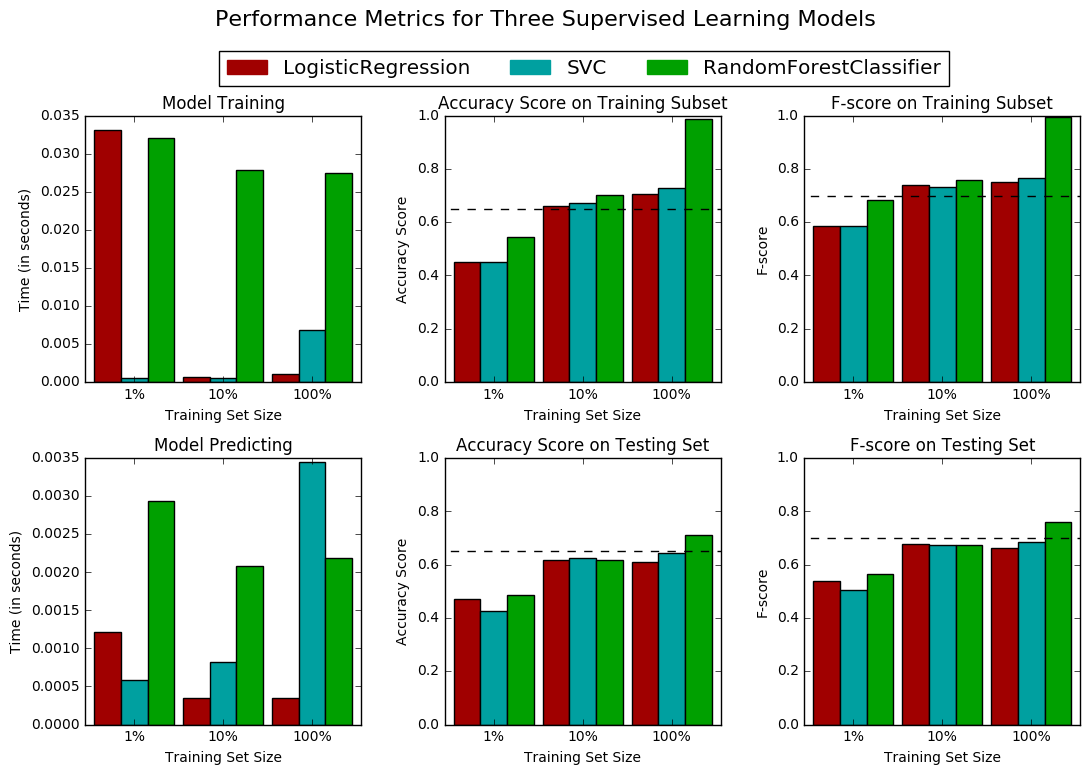

In [6]:
# The following code is adapted from the code from the Udacity Project "Finding Donors"

# Import the three supervised learning models from sklearn
#from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# TODO: Initialize the three models
clf_A = RandomForestClassifier(n_estimators=10, random_state=1)
clf_B = SVC(random_state=2)
clf_C = LogisticRegression(random_state=3)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]/100
#print "Training set has {} samples.".format(X_train.shape[0])
#print samples_1
samples_10 = X_train.shape[0]/10
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Optimize models

As the above tests indicate that the performance, as measured by the F-score and the Accuracy Score, of the Support Vector Machines classifier and Random Forest classifier is better than the Logistic Regression Classifier in the Testing set when all training set samples are used for training, I will optimize the model parameters using a grid seach method with cross validation.

In [18]:
# The following code is adapted from the code from the Udacity Project "Finding Donors"
# Optimze the KNN model

# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn import grid_search
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = neighbors.KNeighborsClassifier(n_neighbors=4)

# Create the parameters list you wish to tune
parameters = {'n_neighbors':range(1,5), 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], \
             'weights':['uniform', 'distance']}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = grid_search.GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=6)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.6261
F-score on testing data: 0.7026

Optimized Model
------
Final accuracy score on the testing data: 0.6522
Final F-score on the testing data: 0.7123


In [11]:
# The following code is adapted from the code from the Udacity Project "Finding Donors"
# Optimze the Support Vector Machines model

# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn import grid_search
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = SVC(random_state=2)

# Create the parameters list you wish to tune
parameters = {'C':np.logspace(-2,2,num=5), 'kernel':['linear', 'rbf']}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = grid_search.GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=6)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.6435
F-score on testing data: 0.6846

Optimized Model
------
Final accuracy score on the testing data: 0.6609
Final F-score on the testing data: 0.7042


In [20]:
# The following code is adapted from the code from the Udacity Project "Finding Donors"
# Optimze the Random Forest model

# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn import grid_search
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(random_state=1)

# Create the parameters list you wish to tune
parameters = {'n_estimators':range(10,30), 'criterion':['gini', 'entropy'], \
              'max_features':['auto', 'sqrt', 'log2']}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = grid_search.GridSearchCV(clf, param_grid=parameters, scoring=scorer, cv=6)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.7130
F-score on testing data: 0.7597

Optimized Model
------
Final accuracy score on the testing data: 0.7130
Final F-score on the testing data: 0.7597


### Final Model Evaluation

##### Results


|     Metric     | Benchmark Predictor | Unoptimized RF Model | Optimized RF Model | Unoptimized KNN Model | Optimized KNN Model | Unoptimized SVM Model | Optimized SVM Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.6504                   | 0.7130                  |   0.7130              | 0.6261                  |   0.6522              | 0.6435                  |   0.6609              |
| F-score        |  0.6993                   | 0.7597                  |   0.7597       | 0.7026                  |   0.7123       | 0.6846                  |   0.7042       |

## 5. Feature importance

### Rank feature importance using Random Forest model

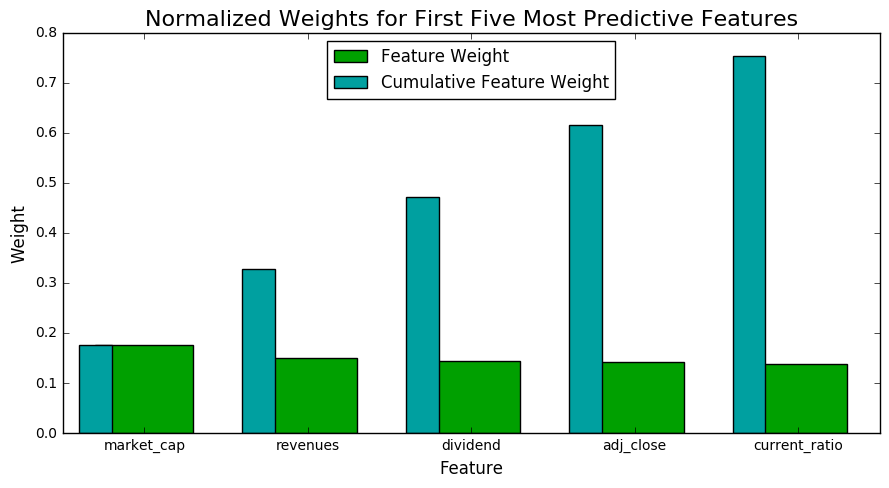

In [23]:
# The following code is copied from the code from the Udacity Project "Finding Donors"

# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Train the supervised model on the training set 
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

## 6. Evaluate classifier using only important features

In [24]:
# The following code is copied from the code from the Udacity Project "Finding Donors"

# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.7130
F-score on testing data: 0.7597

Final Model trained on reduced data
------
Accuracy on testing data: 0.6609
F-score on testing data: 0.7249


## 7. Sensitivity analysis for the Random Forest classifier

To examine how the classifier's predictive capability was affected when the training and testing set were perturbed, I re-shuffled the dataset using a different random_seed and created a re-shuffled training and testing set. Then I re-evaluated the performance of the Random Forest classifier. Different random_state parameters (1,2,3,...20) were used to run the following code to generate the various performance results for each shuffled testing dataset.

In [49]:
import pandas as pd
# Import train_test_split
from sklearn.cross_validation import train_test_split
import numpy as np

# Load the data
data = pd.read_csv("consumer_staples_stocks_report_until_2015_out_preprocessed.csv")

# Split the data into features and target label
gain = data['gain']
features = data.drop('gain', axis = 1)

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, gain, test_size = 0.2, random_state = 20)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])


# The following code is adapted from the code from the Udacity Project "Finding Donors"
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier(random_state=1)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)

# Report the before-and-afterscores
print "Random Forest model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))

Training set has 460 samples.
Testing set has 115 samples.
Random Forest model
------
Accuracy score on testing data: 0.6609
F-score on testing data: 0.7069


### Perform One-sample t test on the mean of the accuracy score and mean of the F-beta score from the above shuffled testing sets

In [53]:
from scipy import stats

accuracy_score_array = [0.6435,0.6435,0.713,0.6435,0.5565,0.6261,0.6783,0.7043,0.687,0.6087,\
                        0.7391,0.6783,0.5739,0.687,0.6957,0.6696,0.6261,0.6783,0.6348,0.6609]
accuracy_score_ttest_1sample = stats.ttest_1samp(accuracy_score_array, 0.6504)
print accuracy_score_ttest_1sample

f_beta_score_array = [0.7459,0.7143,0.7597,0.7413,0.6295,0.6997,0.7507,0.7701,0.7722,0.7232,\
                      0.8065,0.7382,0.7205,0.7385,0.7767,0.7843,0.7434,0.7345,0.7662,0.7069]
f_beta_score_ttest_1sample = stats.ttest_1samp(f_beta_score_array, 0.6993)
print f_beta_score_ttest_1sample



Ttest_1sampResult(statistic=0.68942121363536102, pvalue=0.49889232620732726)
Ttest_1sampResult(statistic=4.944657359166003, pvalue=8.9968867901132232e-05)


### Boxplot of the 20 F-beta scores from the Random Forest model on the 20 shuffled testing sets

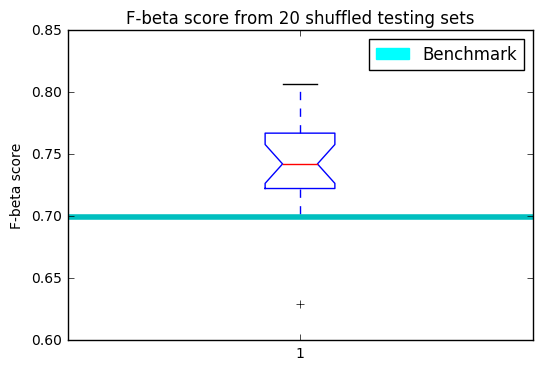

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


f_beta_score_array = [0.7459,0.7143,0.7597,0.7413,0.6295,0.6997,0.7507,0.7701,0.7722,0.7232,\
                      0.8065,0.7382,0.7205,0.7385,0.7767,0.7843,0.7434,0.7345,0.7662,0.7069]

# I referred to the following when learning about matplotlib plots
# http://stackoverflow.com/questions/33382619/plot-a-horizontal-line-using-matplotlib

red_patch = mpatches.Patch(color='cyan', label='Benchmark')
plt.legend(handles=[red_patch])

plt.title('F-beta score from 20 shuffled testing sets')
plt.boxplot(f_beta_score_array, notch=True)
plt.axhline(y=0.6993, color='c', linestyle='-', linewidth=4)
ax = plt.gca()
ax.set_ylabel('F-beta score')


